# Analysis of outlier proteins/metabolites found among samples with high HbA1C in the Arivale dataset

Note: the main idea here is to test various graph analysis methods, not to build a rigorous characterization of Arivale outliers.

In [1]:
# imports
import numpy as np
import pandas as pd
import networkx as nx
import kgfe

## 1. Load data

In [2]:
prots_data = pd.read_csv('../data/prots_hba1c_outliers_2023_07_21.csv', index_col=0)

In [3]:
mets_data = pd.read_csv('../data/mets_hba1c_outliers_2023_07_21.csv', index_col=0)

In [4]:
prots_data.sort_values('outlier_frequency_in_diabetes', ascending=False).head(10)

,name,uniprot,gene_name,outlier_frequency_in_diabetes,outlier_frequency_in_pre_diab
index,,,,,
CVD3_Q99988,CVD3_Q99988,Q99988,GDF15,0.302521,0.150538
CVD3_P07339,CVD3_P07339,P07339,CTSD,0.243697,0.139785
CVD2_P18510,CVD2_P18510,P18510,IL1RN,0.226891,0.086022
CVD2_Q9UJM8,CVD2_Q9UJM8,Q9UJM8,HAO1,0.218487,0.107527
CVD2_Q9BYF1,CVD2_Q9BYF1,Q9BYF1,ACE2,0.210084,0.139785
CVD2_P35442,CVD2_P35442,P35442,THBS2,0.210084,0.075269
CVD2_Q96D42,CVD2_Q96D42,Q96D42,HAVCR1,0.210084,0.053763
INF_P78556,INF_P78556,P78556,CCL20,0.210084,0.139785
INF_Q9H5V8,INF_Q9H5V8,Q9H5V8,CDCP1,0.193277,0.129032


In [5]:
mets_data.sort_values('outlier_frequency_in_diabetes', ascending=False)

,index,CHEMBL,KEGG,PUBCHEM,outlier_frequency_in_diabetes,outlier_frequency_in_pre_diab
CHEMICAL_ID,,,,,,
572,glucose,CHEMBL1222250,C00031,5793.0,0.789916,0.193548
803,mannose,CHEMBL469448,C00159,18950.0,0.588235,0.172043
100020419,1-carboxyethylphenylalanine,NaN,NaN,NaN,0.554622,0.311828
823,pyruvate,CHEMBL1162144,C00022,1060.0,0.436975,0.129032
999946512,X - 21467,NaN,NaN,NaN,0.403361,0.182796
...,...,...,...,...,...,...
100004329,"sphingomyelin (d18:2/16:0, d18:1/16:1)*",NaN,NaN,NaN,0.000000,0.043011
100004509,S-allylcysteine,CHEMBL1592541,NaN,98280.0,0.000000,0.000000
100004555,benzoylcarnitine*,NaN,NaN,NaN,0.000000,0.000000


In [6]:
(prots_data.outlier_frequency_in_diabetes> 0).sum()

252

In [7]:
top_prots = prots_data.sort_values('outlier_frequency_in_diabetes', ascending=False).head(20)
top_mets = mets_data.sort_values('outlier_frequency_in_diabetes', ascending=False).head(20)

## 2. Load SPOKE

In [8]:
import igraph as ig

In [9]:
spoke_graph = kgfe.spoke_loader.load_spoke_igraph('../../graph_utils/spoke_2021.jsonl.gz', directed=True,
                                                    verbose=False)

In [10]:
spoke_graph_ud = spoke_graph.copy()
spoke_graph_ud.to_undirected(combine_edges='first')
spoke_graph_ud.simplify(combine_edges='first')

In [11]:
# TODO: identify the largest connected component
ccs = spoke_graph_ud.connected_components()

In [12]:
names_to_ids = kgfe.graph_info.get_names_to_ids(spoke_graph_ud)

### Load smaller versions of spoke

### Map proteins and metabolites to SPOKE nodes

In [14]:
len(names_to_ids)

617546

In [15]:
uniprot_to_ids = kgfe.graph_info.spoke_identifiers_to_ids(spoke_graph_ud, 'Protein')

In [16]:
chembl_to_ids = kgfe.graph_info.spoke_identifiers_to_ids(spoke_graph_ud, 'Compound')

In [17]:
high_prots = top_prots['uniprot']
high_chems = top_mets[(~top_mets['CHEMBL'].isna())]['CHEMBL']


In [18]:
high_chems_kegg = top_mets[(~top_mets['KEGG'].isna())]['KEGG']


In [19]:
high_prots_spoke_ids = [uniprot_to_ids[x] for x in high_prots]

In [20]:
all_prots_spoke_ids = [uniprot_to_ids[x] for x in prots_data['uniprot'] if x in uniprot_to_ids]

In [21]:
high_prots_spoke_ids

['2150566',
 '2118004',
 '2119057',
 '2156777',
 '2151621',
 '2119871',
 '2148547',
 '2121500',
 '2152837',
 '2114801',
 '2120932',
 '2119931',
 '2123307',
 '2123408',
 '2118946',
 '2117905',
 '2117568',
 '2119835',
 '2117905',
 '2158415']

In [22]:
high_chems_spoke_ids = [(x, chembl_to_ids[x]) for x in high_chems if  x in chembl_to_ids]

In [23]:
high_chems_spoke_ids

[('CHEMBL1222250', '294279'), ('CHEMBL469448', '622101')]

Note: many chems were not able to be mapped onto SPOKE.

In [24]:
high_chems_kegg_spoke_ids = [(x, chembl_to_ids[x]) for x in top_mets['KEGG'] if  x in chembl_to_ids]

In [25]:
len([x for x in chembl_to_ids.keys() if x.startswith('C0')])

2387

In [26]:
high_chems_kegg_spoke_ids

[]

In [27]:
len(all_prots_spoke_ids)

1187

### TODO: Compare the identified nodes against a null model.

In [29]:
spoke_graph_ud_connected = spoke_graph_ud.subcomponent(high_prots_spoke_ids[0])
spoke_graph_ud_connected = spoke_graph_ud.induced_subgraph(spoke_graph_ud_connected)

In [30]:
len(high_prots_spoke_ids)

20

In [31]:
%time high_prots_stats = kgfe.explanations.graph_node_stats(spoke_graph_ud_connected, list(set(high_prots_spoke_ids)))

         403 function calls in 0.134 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       18    0.133    0.007    0.133    0.007 {method 'get_shortest_paths' of 'igraph._igraph.GraphBase' objects}
        1    0.001    0.001    0.134    0.134 explanations.py:99(graph_node_stats)
       18    0.000    0.000    0.000    0.000 {method 'extend' of 'list' objects}
      189    0.000    0.000    0.000    0.000 explanations.py:131(<genexpr>)
        1    0.000    0.000    0.134    0.134 {built-in method builtins.exec}
      173    0.000    0.000    0.000    0.000 {built-in method builtins.len}
        1    0.000    0.000    0.134    0.134 <string>:1(<module>)
        1    0.000    0.000    0.000    0.000 {built-in method builtins.sum}
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}

In [32]:
%time high_prots_null_results = kgfe.explanations.null_graph_stats(spoke_graph_ud_connected, 'Protein', len(high_prots_spoke_ids))

         789303 function calls (789299 primitive calls) in 167.458 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      100  166.420    1.664  166.420    1.664 {method 'distances' of 'igraph._igraph.GraphBase' objects}
        1    0.729    0.729    1.004    1.004 graph_info.py:220(nodes_in_category)
   619452    0.265    0.000    0.265    0.000 {method 'attributes' of 'igraph.Vertex' objects}
   157323    0.010    0.000    0.010    0.000 {method 'append' of 'list' objects}
        1    0.009    0.009    0.009    0.009 explanations.py:218(<listcomp>)
      100    0.008    0.000  166.431    1.664 explanations.py:99(graph_node_stats)
     2000    0.007    0.000    0.007    0.000 {method 'add' of 'set' objects}
     1900    0.003    0.000    0.003    0.000 {method 'extend' of 'list' objects}
      100    0.002    0.000    0.011    0.000 random.py:406(sample)
        1    0.001    0.001  167.457  167.457 explanations.py:199(nu

In [33]:
%time high_prots_null_results_arivale_prots = kgfe.explanations.null_graph_stats(spoke_graph_ud_connected, 'Protein', len(high_prots_spoke_ids),\
                                                                   ids_subset=all_prots_spoke_ids)

         13118 function calls in 123.318 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       99  122.769    1.240  122.769    1.240 {method 'distances' of 'igraph._igraph.GraphBase' objects}
       18    0.525    0.029    0.525    0.029 {method 'get_shortest_paths' of 'igraph._igraph.GraphBase' objects}
     1899    0.010    0.000    0.010    0.000 {method 'extend' of 'list' objects}
      100    0.008    0.000  123.313    1.233 explanations.py:99(graph_node_stats)
      100    0.002    0.000    0.005    0.000 random.py:406(sample)
     2015    0.001    0.000    0.002    0.000 random.py:239(_randbelow_with_getrandbits)
        1    0.001    0.001  123.318  123.318 explanations.py:199(null_graph_stats)
     2000    0.000    0.000    0.000    0.000 {method 'add' of 'set' objects}
     3406    0.000    0.000    0.000    0.000 {method 'getrandbits' of '_random.Random' objects}
      100    0.000    0.000    0.000    0.000 {b

In [34]:
high_prots_null_results = pd.DataFrame(high_prots_null_results)


In [35]:
high_prots_null_results.mean()

average_pairwise_distance    5.119632
dtype: float64

In [31]:
import matplotlib.pyplot as plt

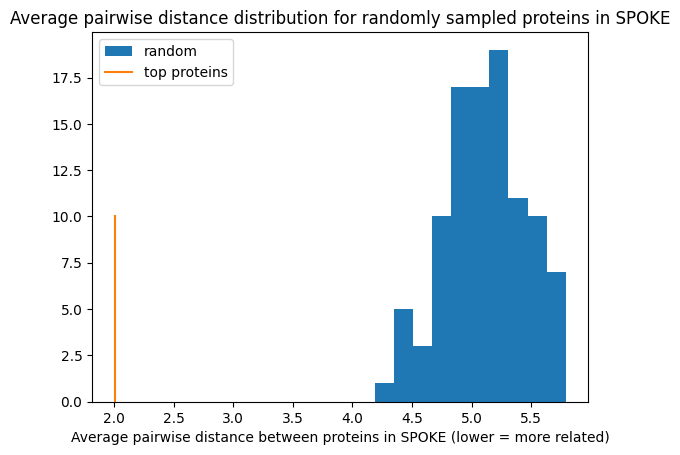

In [43]:
plt.hist(high_prots_null_results.average_pairwise_distance, bins=10, label='random')
plt.title('Average pairwise distance distribution for randomly sampled proteins in SPOKE')
plt.plot([high_prots_stats['average_pairwise_distance'], high_prots_stats['average_pairwise_distance']], [0, 10], label='top proteins')
plt.xlabel('Average pairwise distance between proteins in SPOKE (lower = more related)')
plt.legend()

In [41]:
high_prots_null_results_arivale_prots = pd.DataFrame(high_prots_null_results_arivale_prots)


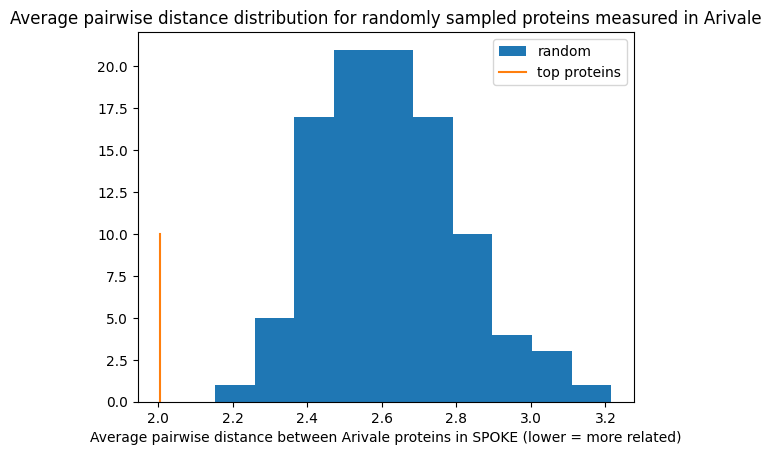

In [44]:
plt.hist(high_prots_null_results_arivale_prots.average_pairwise_distance, bins=10, label='random')
plt.title('Average pairwise distance distribution for randomly sampled proteins measured in Arivale')
plt.plot([high_prots_stats['average_pairwise_distance'], high_prots_stats['average_pairwise_distance']], [0, 10], label='top proteins')
plt.xlabel('Average pairwise distance between Arivale proteins in SPOKE (lower = more related)')
plt.legend()

## Compare outlier degree distributions against degree distributions from all arivale proteins

In [28]:
prot_degrees = spoke_graph_ud.degree(all_prots_spoke_ids)

In [29]:
sample_degrees = spoke_graph_ud.degree(high_prots_spoke_ids)

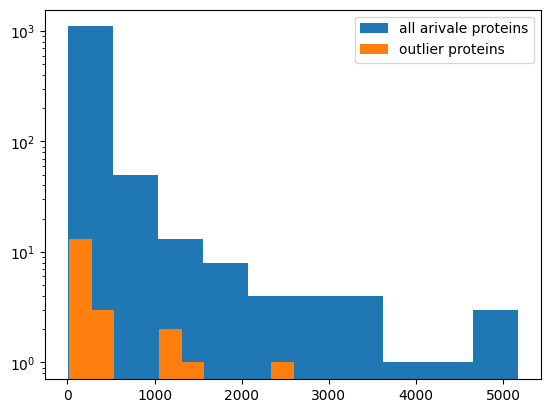

In [32]:
plt.hist(prot_degrees, label='all arivale proteins')
plt.hist(sample_degrees, label='outlier proteins')
plt.yscale('log')
plt.legend()

## 3. Run topic PageRank

TODO: this is copied from feature_analysis_2 - change to arivale outlier data.

In [39]:
high_prots_pr_results, high_prots_top_nodes = kgfe.explanations.topic_pagerank(spoke_graph_ud, high_prots_spoke_ids)

In [40]:
low_prots_pr_results, low_prots_top_nodes = kgfe.explanations.topic_pagerank(spoke_graph_ud, low_prots_spoke_ids)

In [41]:
high_chems_pr_results, high_chems_top_nodes = kgfe.explanations.topic_pagerank(spoke_graph_ud, [x[1] for x in high_chems_spoke_ids])

In [42]:
low_chems_pr_results, low_chems_top_nodes = kgfe.explanations.topic_pagerank(spoke_graph_ud, [x[1] for x in low_chems_spoke_ids])

In [43]:
high_prots_top_proteins = [x for x in high_prots_top_nodes if x['category'] == 'Protein']
high_prots_top_genes = [x for x in high_prots_top_nodes if x['category'] == 'Gene']

## 4. Plot PageRank results

In [44]:
import matplotlib.pyplot as plt

### Proteins with positive Lasso_CV scores

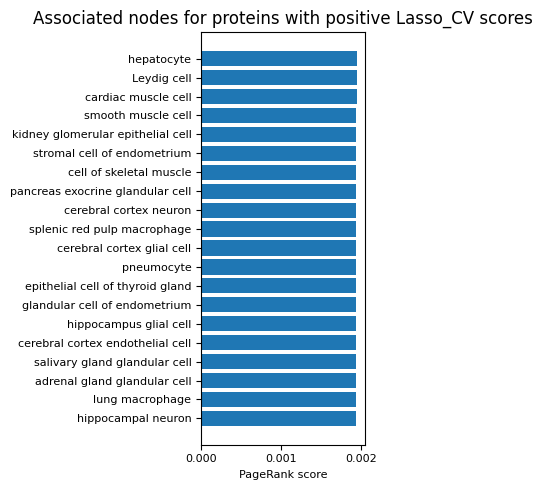

In [45]:
fig, ax = plt.subplots(figsize=(4, 5))
ax.tick_params(axis='both', which='major', labelsize=8)
ax.barh([x['feature_name'] for x in high_prots_top_nodes[:20][::-1]], [x['score'] for x in high_prots_top_nodes[:20][::-1]], )
plt.title('Associated nodes for proteins with positive Lasso_CV scores')
ax.set_xlabel('PageRank score', fontsize=8)
plt.tight_layout()

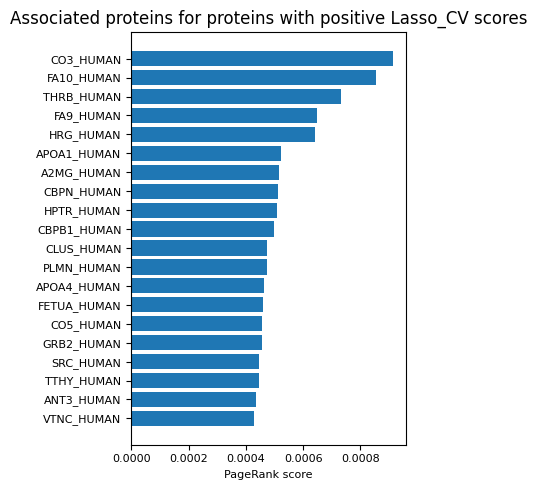

In [46]:
high_prots_top_proteins = [x for x in high_prots_top_nodes if x['category'] == 'Protein']

fig, ax = plt.subplots(figsize=(4, 5))
ax.tick_params(axis='both', which='major', labelsize=8)
ax.barh([x['feature_name'] for x in high_prots_top_proteins[:20][::-1]], [x['score'] for x in high_prots_top_proteins[:20][::-1]], )
plt.title('Associated proteins for proteins with positive Lasso_CV scores')
ax.set_xlabel('PageRank score', fontsize=8)
plt.tight_layout()

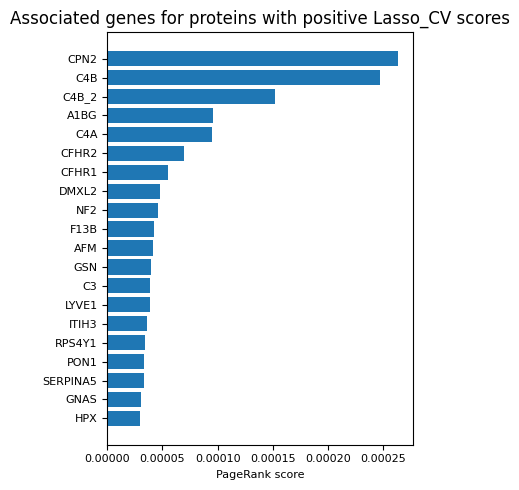

In [47]:
high_prots_top_genes = [x for x in high_prots_top_nodes if x['category'] == 'Gene']

fig, ax = plt.subplots(figsize=(4, 5))
ax.tick_params(axis='both', which='major', labelsize=8)
ax.barh([x['feature_name'] for x in high_prots_top_genes[:20][::-1]], [x['score'] for x in high_prots_top_genes[:20][::-1]], )
plt.title('Associated genes for proteins with positive Lasso_CV scores')
ax.set_xlabel('PageRank score', fontsize=8)
plt.tight_layout()

### Proteins with negative Lasso_CV scores

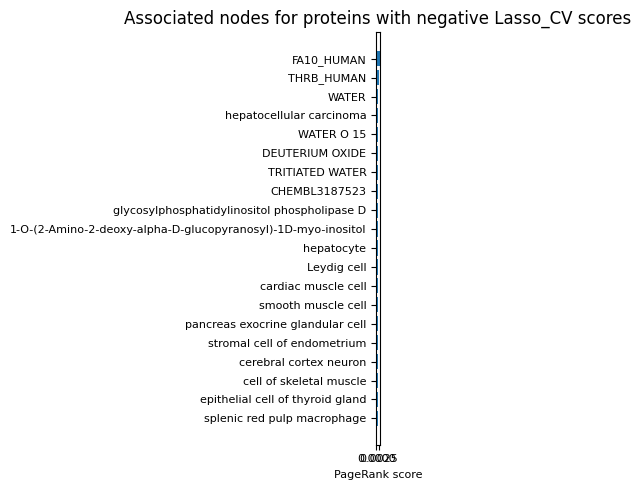

In [48]:
fig, ax = plt.subplots(figsize=(4, 5))
ax.tick_params(axis='both', which='major', labelsize=8)
ax.barh([x['feature_name'] for x in low_prots_top_nodes[:20][::-1]], [x['score'] for x in low_prots_top_nodes[:20][::-1]], )
plt.title('Associated nodes for proteins with negative Lasso_CV scores')
ax.set_xlabel('PageRank score', fontsize=8)
plt.tight_layout()

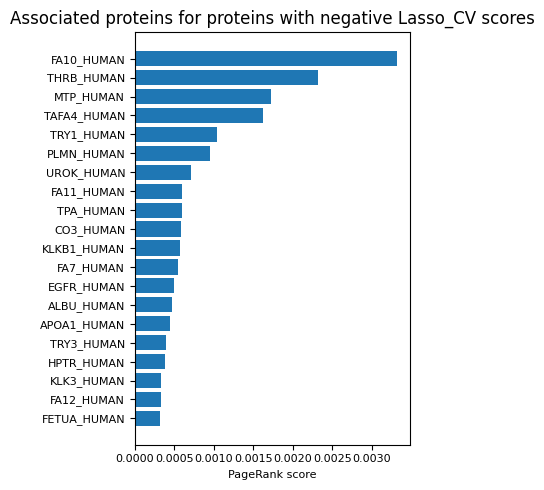

In [49]:
low_prots_top_proteins = [x for x in low_prots_top_nodes if x['category'] == 'Protein']

fig, ax = plt.subplots(figsize=(4, 5))
ax.tick_params(axis='both', which='major', labelsize=8)
ax.barh([x['feature_name'] for x in low_prots_top_proteins[:20][::-1]], [x['score'] for x in low_prots_top_proteins[:20][::-1]], )
plt.title('Associated proteins for proteins with negative Lasso_CV scores')
ax.set_xlabel('PageRank score', fontsize=8)
plt.tight_layout()

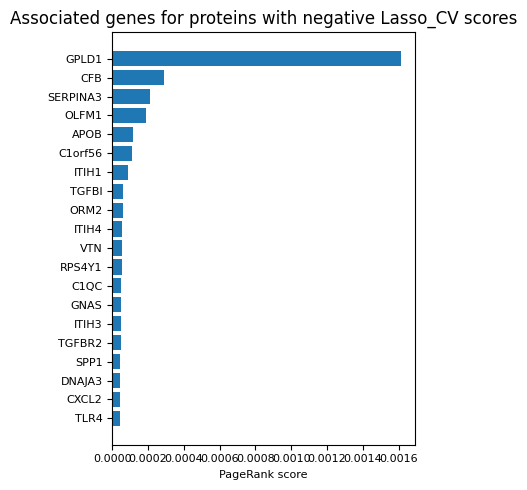

In [50]:
low_prots_top_genes = [x for x in low_prots_top_nodes if x['category'] == 'Gene']

fig, ax = plt.subplots(figsize=(4, 5))
ax.tick_params(axis='both', which='major', labelsize=8)
ax.barh([x['feature_name'] for x in low_prots_top_genes[:20][::-1]], [x['score'] for x in low_prots_top_genes[:20][::-1]], )
plt.title('Associated genes for proteins with negative Lasso_CV scores')
ax.set_xlabel('PageRank score', fontsize=8)
plt.tight_layout()

### Chems with positive Lasso_CV scores

/tmp/ipykernel_272233/2546614946.py:6: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


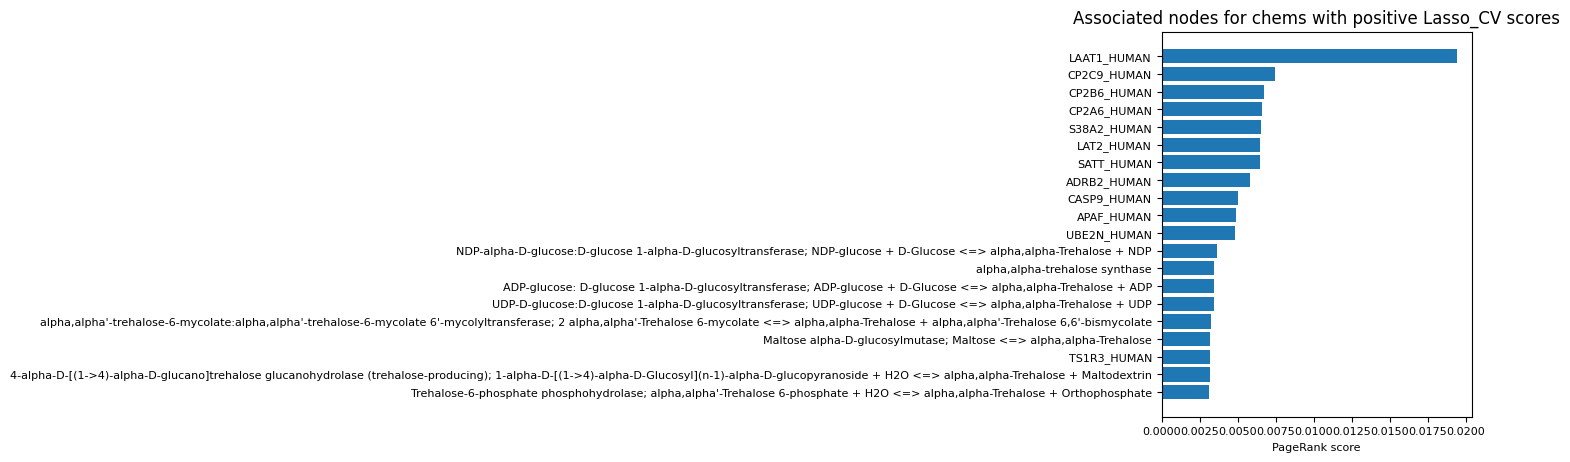

In [51]:
fig, ax = plt.subplots(figsize=(4, 5))
ax.tick_params(axis='both', which='major', labelsize=8)
ax.barh([x['feature_name'] for x in high_chems_top_nodes[:20][::-1]], [x['score'] for x in high_chems_top_nodes[:20][::-1]], )
plt.title('Associated nodes for chems with positive Lasso_CV scores')
ax.set_xlabel('PageRank score', fontsize=8)
plt.tight_layout()

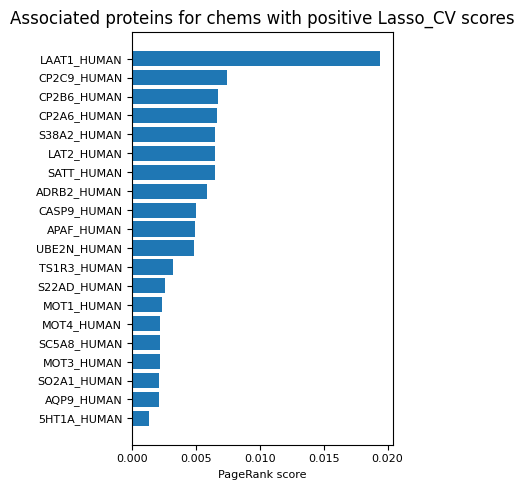

In [52]:
high_chems_top_proteins = [x for x in high_chems_top_nodes if x['category'] == 'Protein']

fig, ax = plt.subplots(figsize=(4, 5))
ax.tick_params(axis='both', which='major', labelsize=8)
ax.barh([x['feature_name'] for x in high_chems_top_proteins[:20][::-1]], [x['score'] for x in high_chems_top_proteins[:20][::-1]], )
plt.title('Associated proteins for chems with positive Lasso_CV scores')
ax.set_xlabel('PageRank score', fontsize=8)
plt.tight_layout()

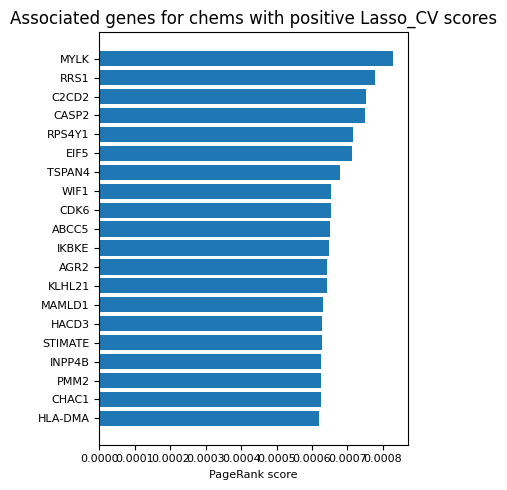

In [53]:
high_chems_top_genes = [x for x in high_chems_top_nodes if x['category'] == 'Gene']

fig, ax = plt.subplots(figsize=(4, 5))
ax.tick_params(axis='both', which='major', labelsize=8)
ax.barh([x['feature_name'] for x in high_chems_top_genes[:20][::-1]], [x['score'] for x in high_chems_top_genes[:20][::-1]], )
plt.title('Associated genes for chems with positive Lasso_CV scores')
ax.set_xlabel('PageRank score', fontsize=8)
plt.tight_layout()

/tmp/ipykernel_272233/1194101335.py:8: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


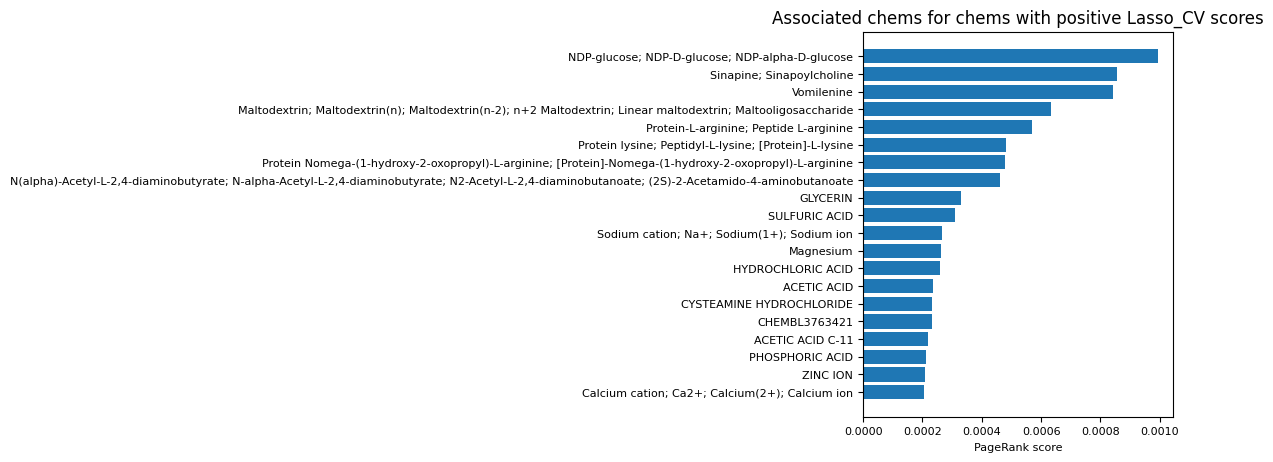

In [54]:
high_chems_top_chems = [x for x in high_chems_top_nodes if x['category'] == 'Compound']

fig, ax = plt.subplots(figsize=(4, 5))
ax.tick_params(axis='both', which='major', labelsize=8)
ax.barh([x['feature_name'] for x in high_chems_top_chems[:20][::-1]], [x['score'] for x in high_chems_top_chems[:20][::-1]], )
plt.title('Associated chems for chems with positive Lasso_CV scores')
ax.set_xlabel('PageRank score', fontsize=8)
plt.tight_layout()

### Chems with negative Lasso_CV scores

/tmp/ipykernel_272233/3090059252.py:6: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


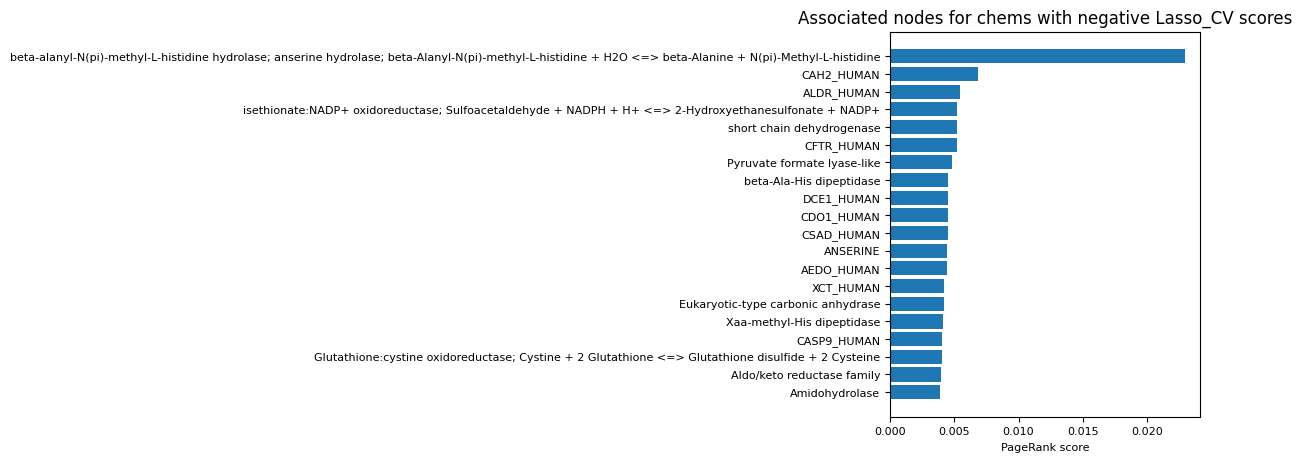

In [55]:
fig, ax = plt.subplots(figsize=(4, 5))
ax.tick_params(axis='both', which='major', labelsize=8)
ax.barh([x['feature_name'] for x in low_chems_top_nodes[:20][::-1]], [x['score'] for x in low_chems_top_nodes[:20][::-1]], )
plt.title('Associated nodes for chems with negative Lasso_CV scores')
ax.set_xlabel('PageRank score', fontsize=8)
plt.tight_layout()

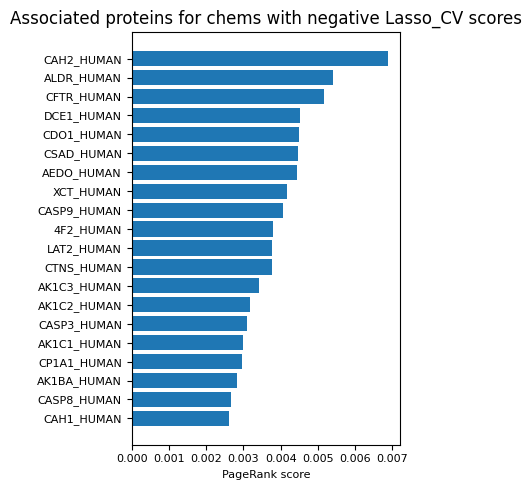

In [56]:
low_chems_top_proteins = [x for x in low_chems_top_nodes if x['category'] == 'Protein']

fig, ax = plt.subplots(figsize=(4, 5))
ax.tick_params(axis='both', which='major', labelsize=8)
ax.barh([x['feature_name'] for x in low_chems_top_proteins[:20][::-1]], [x['score'] for x in low_chems_top_proteins[:20][::-1]], )
plt.title('Associated proteins for chems with negative Lasso_CV scores')
ax.set_xlabel('PageRank score', fontsize=8)
plt.tight_layout()

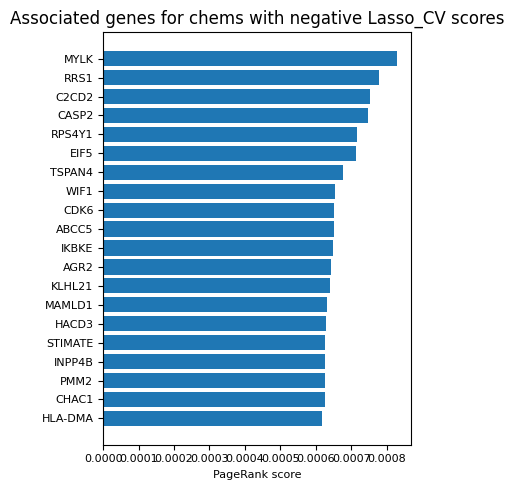

In [57]:
low_chems_top_genes = [x for x in high_chems_top_nodes if x['category'] == 'Gene']

fig, ax = plt.subplots(figsize=(4, 5))
ax.tick_params(axis='both', which='major', labelsize=8)
ax.barh([x['feature_name'] for x in low_chems_top_genes[:20][::-1]], [x['score'] for x in low_chems_top_genes[:20][::-1]], )
plt.title('Associated genes for chems with negative Lasso_CV scores')
ax.set_xlabel('PageRank score', fontsize=8)
plt.tight_layout()

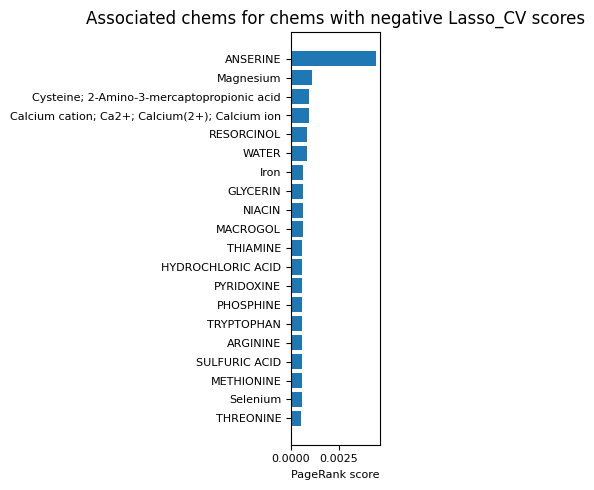

In [58]:
low_chems_top_chems = [x for x in low_chems_top_nodes if x['category'] == 'Compound']

fig, ax = plt.subplots(figsize=(4, 5))
ax.tick_params(axis='both', which='major', labelsize=8)
ax.barh([x['feature_name'] for x in low_chems_top_chems[:20][::-1]], [x['score'] for x in low_chems_top_chems[:20][::-1]], )
plt.title('Associated chems for chems with negative Lasso_CV scores')
ax.set_xlabel('PageRank score', fontsize=8)
plt.tight_layout()

## 5. Get Steiner trees / subgraphs

In [59]:
high_protein_st, high_protein_subgraph = kgfe.explanations.steiner_tree_subgraph(spoke_graph_ud,
                                                                                 high_prots_spoke_ids,
                                                                                 method='takahashi')

In [60]:
low_protein_st, low_protein_subgraph = kgfe.explanations.steiner_tree_subgraph(spoke_graph_ud,
                                                                              low_prots_spoke_ids,
                                                                              method='takahashi')

In [61]:
# TODO: get a connected component from the first chem?

In [62]:
high_chems_st, high_chems_subgraph = kgfe.explanations.steiner_tree_subgraph(spoke_graph_ud,
                                                                            [x[1] for x in high_chems_spoke_ids],
                                                                            method='takahashi')

In [63]:
low_chems_st, low_chems_subgraph = kgfe.explanations.steiner_tree_subgraph(spoke_graph_ud,
                                                                          [x[1] for x in low_chems_spoke_ids],
                                                                          method='takahashi')

## Visualizing subgraphs

In [64]:
import ipycytoscape

In [65]:
# TODO: display the node category somewhere, and display the edge categories
graph_style = [{
                        'selector': 'node[feature_name]',
                             'style': {
                                  'font-family': 'helvetica',
                                  'font-size': '20px',
                                 'label': 'data(feature_name)',
                        }},
                        {'selector': 'node[category="Protein"]',
                         'style': {
                             'background-color': 'blue',
                         }},
                        {'selector': 'node[in_query=1]',
                         'style': {
                             'border-width': '5px',
                             'border-color': 'red',
                         }},
                        {'selector': 'edge[type]',
                         'style': {
                             'label': 'data(type)',
                         }},
                        {"selector": "edge.directed",
                         "style": {
                            "curve-style": "bezier",
                            "target-arrow-shape": "triangle",
                    }},

                    ]

In [66]:
undirected = ipycytoscape.CytoscapeWidget()
high_protein_subgraph_nx = high_protein_subgraph.to_networkx()
node_dict = {i: n['name'] for i, n in high_protein_subgraph_nx.nodes.items()}
high_protein_subgraph_nx = nx.relabel_nodes(high_protein_subgraph_nx, node_dict)
undirected.graph.add_graph_from_networkx(high_protein_subgraph_nx)
undirected.set_tooltip_source('feature_name')
undirected.set_layout(title='high_proteins', nodeSpacing=80, edgeLengthVal=50, )
undirected.set_style(graph_style)

In [67]:
display(undirected)

CytoscapeWidget(cytoscape_layout={'name': 'cola', 'title': 'high_proteins', 'nodeSpacing': 80, 'edgeLengthVal'…

In [68]:
low_prots_graph = ipycytoscape.CytoscapeWidget()
low_protein_subgraph_nx = low_protein_subgraph.to_networkx()
node_dict = {i: n['name'] for i, n in low_protein_subgraph_nx.nodes.items()}
low_protein_subgraph_nx = nx.relabel_nodes(low_protein_subgraph_nx, node_dict)
low_prots_graph.graph.add_graph_from_networkx(low_protein_subgraph_nx)
low_prots_graph.set_tooltip_source('name')
low_prots_graph.set_layout(nodeSpacing=80, edgeLengthVal=50)
low_prots_graph.set_style(graph_style)

In [69]:
display(low_prots_graph)

CytoscapeWidget(cytoscape_layout={'name': 'cola', 'nodeSpacing': 80, 'edgeLengthVal': 50}, cytoscape_style=[{'…

In [70]:
high_chems_graph = ipycytoscape.CytoscapeWidget()
high_chems_subgraph_nx = high_chems_subgraph.to_networkx()
node_dict = {i: n['name'] for i, n in high_chems_subgraph_nx.nodes.items()}
high_chems_subgraph_nx = nx.relabel_nodes(high_chems_subgraph_nx, node_dict)
high_chems_graph.graph.add_graph_from_networkx(high_chems_subgraph_nx)
high_chems_graph.set_tooltip_source('name')
high_chems_graph.set_layout(nodeSpacing=80, edgeLengthVal=50)
high_chems_graph.set_style(graph_style)

In [71]:
display(high_chems_graph)

CytoscapeWidget(cytoscape_layout={'name': 'cola', 'nodeSpacing': 80, 'edgeLengthVal': 50}, cytoscape_style=[{'…

In [72]:
low_chems_graph = ipycytoscape.CytoscapeWidget()
low_chems_subgraph_nx = low_chems_subgraph.to_networkx()
node_dict = {i: n['name'] for i, n in low_chems_subgraph_nx.nodes.items()}
low_chems_subgraph_nx = nx.relabel_nodes(low_chems_subgraph_nx, node_dict)
low_chems_graph.graph.add_graph_from_networkx(low_chems_subgraph_nx)
low_chems_graph.set_tooltip_source('name')
low_chems_graph.set_layout(nodeSpacing=80, edgeLengthVal=50)
low_chems_graph.set_style(graph_style)

In [73]:
display(low_chems_graph)

CytoscapeWidget(cytoscape_layout={'name': 'cola', 'nodeSpacing': 80, 'edgeLengthVal': 50}, cytoscape_style=[{'…